In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import time
import platform
import psutil

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [2]:
# Datensatz laden
file_path = r"C:\Users\leesh\Desktop\BA\Datensätze\cardiovascular_disease_dataset\L_50\cvd_k50_l50-anonymized.csv"
df = pd.read_csv(file_path, delimiter=";", low_memory=False)

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68184 entries, 0 to 68183
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           68184 non-null  object
 1   age          68184 non-null  object
 2   gender       68184 non-null  object
 3   height       68184 non-null  object
 4   weight       68184 non-null  object
 5   ap_hi        68184 non-null  int64 
 6   ap_lo        68184 non-null  int64 
 7   cholesterol  68184 non-null  int64 
 8   gluc         68184 non-null  int64 
 9   smoke        68184 non-null  int64 
 10  alco         68184 non-null  int64 
 11  active       68184 non-null  int64 
 12  cardio       68184 non-null  int64 
dtypes: int64(8), object(5)
memory usage: 6.8+ MB
None


In [4]:
def calculate_interval_mean(interval):
    try:
        # Entfernen Sie die eckigen Klammern und teilen Sie die Zahlen
        numbers = re.findall(r'\d+', interval)
        if len(numbers) != 2:
            return None
        lower_bound = int(numbers[0])
        upper_bound = int(numbers[1])
    
        # Berechnen des Mittelwerts
        mean_value = (lower_bound + upper_bound) / 2
        return mean_value
    except (ValueError, IndexError):
        return None  # Geben Sie None zurück, wenn es Probleme beim Parsen gibt

# Spalten, die Intervalle enthalten
interval_columns = ['age', 'height', 'weight']

# Ersetzen der Intervalle durch Mittelwerte
for column in interval_columns:
    df[column] = df[column].apply(calculate_interval_mean)

In [5]:
print(df.head())

  id   age gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  *  60.0      1   150.0    80.0    120     70            1     1      0   
1  *  60.0      1   150.0    80.0    100     80            1     1      0   
2  *  60.0      1   150.0    80.0    130     80            2     1      0   
3  *  60.0      1   150.0    80.0    110     80            1     1      0   
4  *  60.0      1   150.0    80.0    140     80            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       0  
2     0       1       0  
3     0       1       0  
4     0       1       1  


In [6]:
# id entfernen
df = df.drop('id', axis=1)

In [7]:
# Entfernen Sie Zeilen mit "*" in einer der Spalten
df = df[~df.isin(['*']).any(axis=1)]

In [8]:
# Konvertieren Sie die Spalte "gender" in den Datentyp int
df['gender'] = df['gender'].astype(int)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62676 entries, 0 to 62675
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          62676 non-null  float64
 1   gender       62676 non-null  int32  
 2   height       62676 non-null  float64
 3   weight       62676 non-null  float64
 4   ap_hi        62676 non-null  int64  
 5   ap_lo        62676 non-null  int64  
 6   cholesterol  62676 non-null  int64  
 7   gluc         62676 non-null  int64  
 8   smoke        62676 non-null  int64  
 9   alco         62676 non-null  int64  
 10  active       62676 non-null  int64  
 11  cardio       62676 non-null  int64  
dtypes: float64(3), int32(1), int64(8)
memory usage: 6.0 MB


In [10]:
# Features und Zielvariable definieren
X = df.drop('cardio', axis=1)
y = df['cardio']

In [11]:
# Daten in Trainings- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Daten normalisieren
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# Starten Sie den Zeitmesser
start_time = time.time()

# Gradient Boosting Modell trainieren
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Stoppen Sie den Zeitmesser
end_time = time.time()
total_time = end_time - start_time

# Sammeln Sie Informationen zu Ihren Computerspezifikationen
cpu_count = psutil.cpu_count()
cpu_freq = psutil.cpu_freq().current
ram = psutil.virtual_memory().total / (1024.0 ** 3)
system = platform.system()
architecture = platform.architecture()[0]

# Speichern Sie die Ergebnisse in einer Textdatei
with open('results/gbc_cvd_k50_l50_performance.txt', 'w') as f:
    f.write(f"Laufzeit: {total_time:.2f} Sekunden\n")
    f.write(f"CPU-Kerne: {cpu_count}\n")
    f.write(f"CPU-Taktfrequenz: {cpu_freq} MHz\n")
    f.write(f"RAM: {ram:.2f} GB\n")
    f.write(f"Betriebssystem: {system}\n")
    f.write(f"Architektur: {architecture}\n")

In [14]:
# Vorhersagen und Evaluierung
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
classification_report_str = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

with open('results/gbc_cvd_k50_l50_model_evaluation.txt', 'w') as file:
    file.write('Classification Report:\n')
    file.write(classification_report_str)
    file.write('\nAccuracy: {:.4f}\n'.format(accuracy))
    file.write('ROC AUC Score: {:.4f}\n'.format(roc_auc))

print(classification_report_str)
print(f'Accuracy: {accuracy}')
print(f'ROC AUC Score: {roc_auc}')

              precision    recall  f1-score   support

           0       0.70      0.78      0.74      6265
           1       0.75      0.66      0.70      6271

    accuracy                           0.72     12536
   macro avg       0.72      0.72      0.72     12536
weighted avg       0.72      0.72      0.72     12536

Accuracy: 0.7198468410976387
ROC AUC Score: 0.7755219016379505


<Figure size 1000x700 with 0 Axes>

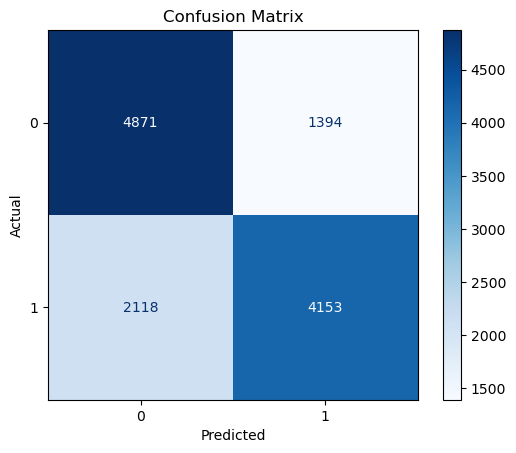

In [15]:
# Erstellen der Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred)

# Visualisieren der Konfusionsmatrix
plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('results/gbc_cvd_k50_l50_confusion_matrix.png', dpi=300)
plt.show()

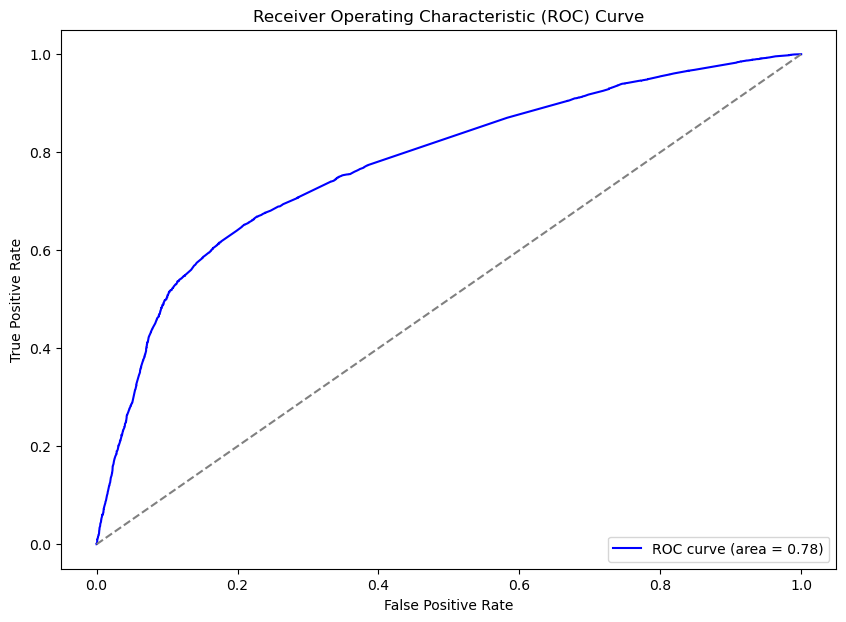

In [16]:
# ROC Kurve plotten
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('results/gbc_cvd_k50_l50_roc_curve.png', dpi=300)
plt.show()

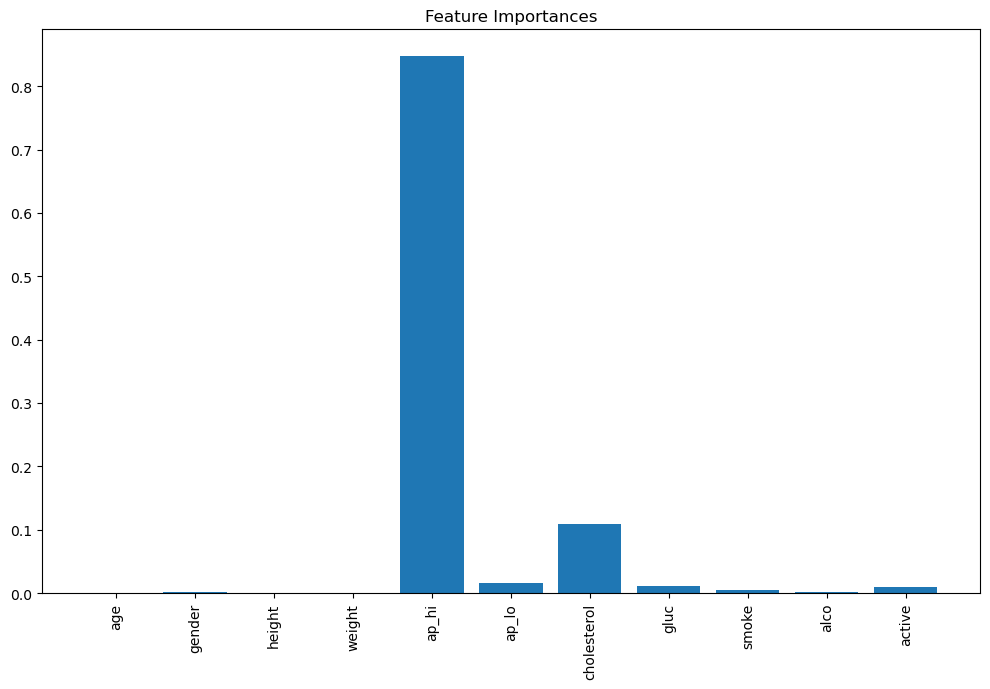

In [17]:
# Feature Importances plotten
feature_importances = model.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 7))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), feature_importances, align='center')
plt.xticks(range(X.shape[1]), features, rotation=90)
plt.tight_layout()
plt.savefig("results/gbc_cvd_k50_l50_feature_importances.png", dpi=300)
plt.show()

<Figure size 1600x1000 with 0 Axes>

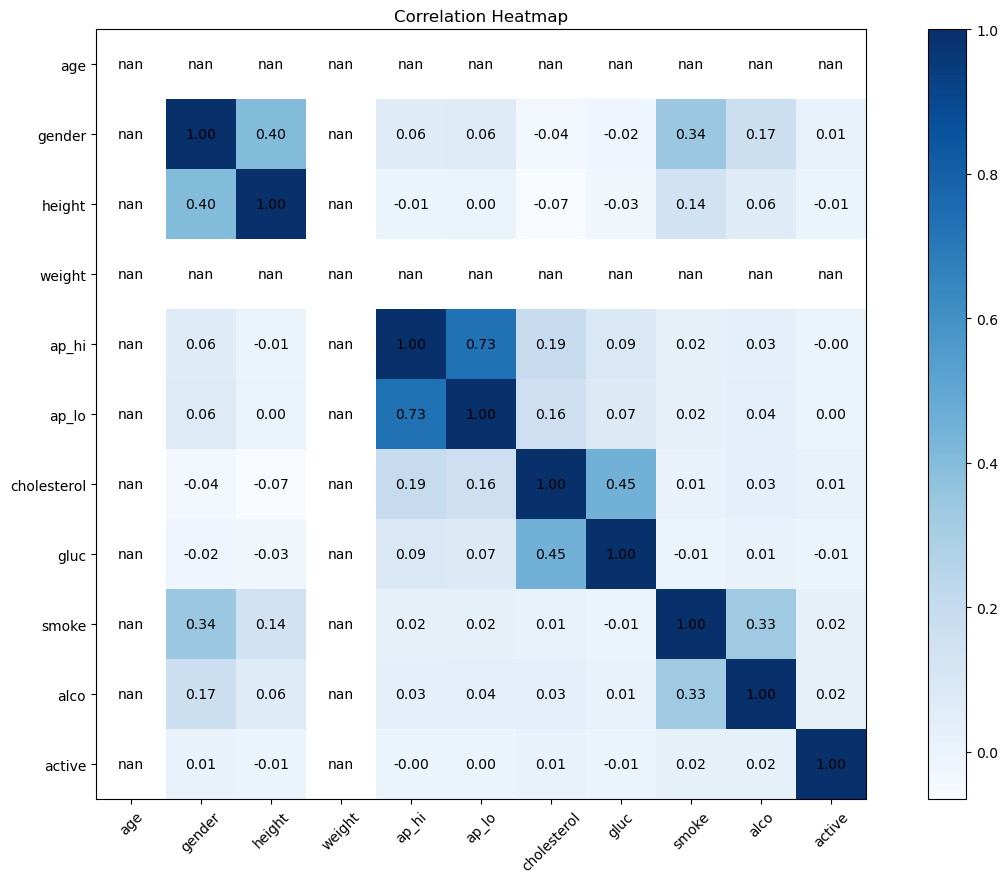

In [18]:
# Create the correlation heatmap
plt.figure(figsize=(16, 10))
correlation_matrix = X.corr()

fig, ax = plt.subplots(figsize=(16, 10))
im = ax.imshow(correlation_matrix, cmap='Blues')
ax.set_xticks(np.arange(len(X.columns)))
ax.set_yticks(np.arange(len(X.columns)))
ax.set_xticklabels(X.columns, rotation=45)
ax.set_yticklabels(X.columns)

# Add the correlation values as text annotations
for i in range(len(X.columns)):
    for j in range(len(X.columns)):
        text = ax.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha="center", va="center", color="black")

plt.colorbar(im)
plt.title("Correlation Heatmap")
plt.savefig("results/gbc_cvd_k50_l50_correlation_heatmap.png", dpi=300)
plt.show()